In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Dissertation'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

Mounted at /content/drive


In [3]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,models,datasets
from torchsummary import summary
import pickle
import csv
import pandas as pd
from datetime import datetime
from PIL import Image
from skimage import io
import numpy as np
from tqdm import tqdm

In [ ]:
seed = 12
torch.manual_seed(seed)

In [ ]:
with open('drive/My Drive/Colab Notebooks/Dissertation/DissertationData/train_loader.pkl', 'rb') as train_file:
    train_loader = pickle.load(train_file)

with open('drive/My Drive/Colab Notebooks/Dissertation/DissertationData/valid_loader.pkl', 'rb') as valid_file:
    valid_loader = pickle.load(valid_file)

with open('drive/My Drive/Colab Notebooks/Dissertation/DissertationData/holdout_loader.pkl', 'rb') as holdout_file:
    holdout_loader = pickle.load(holdout_file)

In [ ]:
# model setup
def get_ResNet():
    model = models.resnet50(weights=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(128, 8))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay = 0.1)
    model = model.to(device)
    return model.to(device), loss_fn, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, loss_fn, optimizer = get_ResNet()

# training and evaluating model
num_epochs = 5
best_val_loss = float('inf')
best_model_weights = None
patience = 5
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_data, batch_stamp, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(batch_data)
        loss = loss_fn(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # valid
    model.eval()
    val_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_data, batch_stamp, batch_labels in valid_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            logits = model(batch_data)
            loss = loss_fn(logits, batch_labels)
            _, predicted = torch.max(logits.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    early_stopping_counter += 1

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model.state_dict()
        early_stopping_counter = 0

    if early_stopping_counter >= patience:
        print("Early stopping! Validation loss did not improve for {} consecutive epochs.".format(patience))
        break

print(f'Accuracy over validation images: {100*correct // total}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.0MB/s]


In [ ]:
# evalutating  model with holdout data
model.eval()
eval_loss = 0.0
total_samples = 0
predicted_probabilities = []
predicted_scores = []
actual_scores = []
cross_entropy = 0.0
num_batches = 0

with torch.no_grad():
    for batch_data, ___, batch_labels in holdout_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        outputs = model(batch_data)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        loss = loss_fn(outputs, batch_labels)
        predicted_probabilities.append(probabilities.cpu().numpy())
        predicted_scores.append(predicted.cpu().numpy())
        actual_scores.append(batch_labels.cpu().numpy())
        eval_loss += loss.item()
        total_samples += batch_labels.size(0)
        cross_entropy += loss.item()
        num_batches += 1
avg_eval_loss = eval_loss / len(holdout_loader)
avg_cross_entropy = cross_entropy / num_batches

# making numpy arrays for dataframe later
predicted_probabilities = np.concatenate(predicted_probabilities)
predicted_scores = np.concatenate(predicted_scores)
actual_scores = np.concatenate(actual_scores)

# Print average cross-entropy loss
print(f'Average Cross-Entropy Loss: {avg_cross_entropy:.4f}')

Average Cross-Entropy Loss: 2.0701


In [ ]:
# holdout dataframe
output = {
    'Actual_Class': actual_scores,
    'Predicted_Class': predicted_scores
}
holdout_df = pd.DataFrame(output)
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

for i, class_name in enumerate(class_names):
    holdout_df[class_name] = predicted_probabilities[:, i]
print(holdout_df)

      Actual_Class  Predicted_Class  antelope_duiker      bird     blank  \
0                0                3         0.143080  0.117733  0.114448   
1                3                3         0.143373  0.117556  0.114335   
2                2                3         0.143346  0.117607  0.114330   
3                3                3         0.143368  0.117573  0.114325   
4                2                3         0.143118  0.117718  0.114404   
...            ...              ...              ...       ...       ...   
1438             0                3         0.143257  0.117647  0.114355   
1439             3                3         0.143392  0.117550  0.114333   
1440             2                3         0.143329  0.117614  0.114325   
1441             2                3         0.143242  0.117659  0.114366   
1442             0                3         0.143397  0.117555  0.114321   

      civet_genet       hog   leopard  monkey_prosimian    rodent  
0        0.168064  

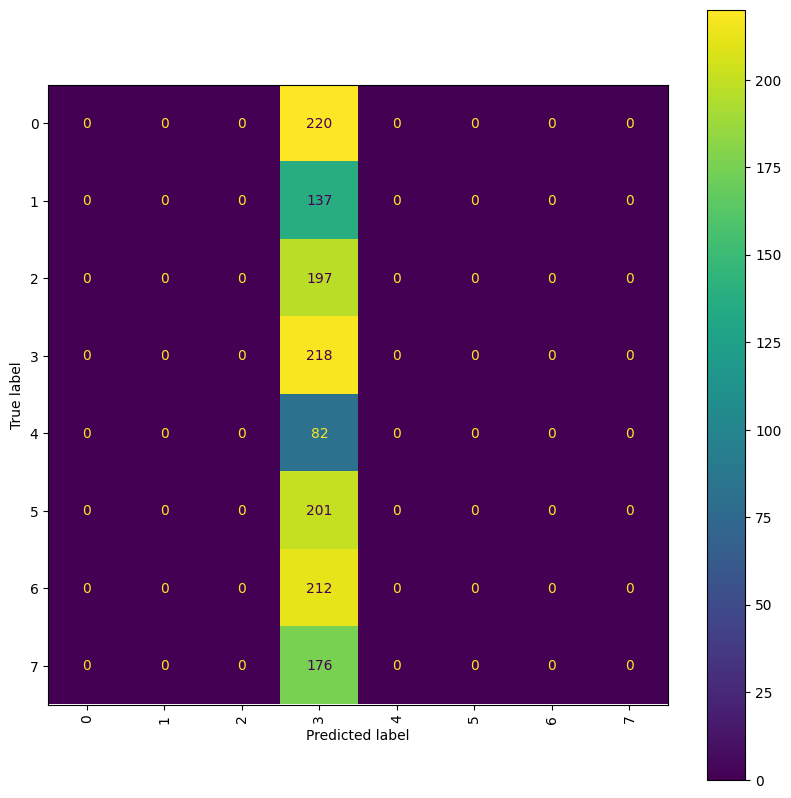

In [ ]:
# confusion matrix for holdout data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion = confusion_matrix(holdout_df['Actual_Class'], holdout_df['Predicted_Class'])
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay(confusion, display_labels=np.unique(actual_values))
cm.plot(ax=ax, xticks_rotation=90, colorbar=True)
plt.show()

## GradCAM

In [5]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00


In [6]:
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms,models,datasets
import torch.nn as nn
import numpy as np
import cv2
from captum.attr import GuidedGradCam

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, _, _ = get_ResNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/model2.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [8]:
# images taken from holdout images
data = {'label': [0, 1, 2, 3, 4, 5, 6, 7],
        'animal': ["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"],
        'img_path': ["/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ007832.jpg",
                     '/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ008987.jpg',
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ008153.jpg",
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ014095.jpg",
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ010530.jpg",
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ010518.jpg",
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ003302.jpg",
                     "/content/drive/MyDrive/Colab Notebooks/Dissertation/DissertationData/ZJ001674.jpg"]}

image_df = pd.DataFrame(data)

In [9]:
# adding mean and std for images to df
def calculate_mean_std(image_path):
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    mean_value = np.mean(image_array)
    std_value = np.std(image_array)
    return mean_value, std_value

image_df['mean'] = 0.0
image_df['std'] = 0.0

for index, row in image_df.iterrows():
    img_path = row['img_path']
    mean_value, std_value = calculate_mean_std(img_path)
    image_df.at[index, 'mean'] = mean_value
    image_df.at[index, 'std'] = std_value

In [10]:
print(image_df)
print(type(image_df['label']))

   label            animal                                           img_path  \
0      0   antelope_duiker  /content/drive/MyDrive/Colab Notebooks/Dissert...   
1      1              bird  /content/drive/MyDrive/Colab Notebooks/Dissert...   
2      2             blank  /content/drive/MyDrive/Colab Notebooks/Dissert...   
3      3       civet_genet  /content/drive/MyDrive/Colab Notebooks/Dissert...   
4      4               hog  /content/drive/MyDrive/Colab Notebooks/Dissert...   
5      5           leopard  /content/drive/MyDrive/Colab Notebooks/Dissert...   
6      6  monkey_prosimian  /content/drive/MyDrive/Colab Notebooks/Dissert...   
7      7            rodent  /content/drive/MyDrive/Colab Notebooks/Dissert...   

         mean        std  
0   53.103434  30.895945  
1  124.049688  43.944102  
2   56.733924  26.402208  
3   84.029575  63.779942  
4   68.994117  20.834762  
5   94.475938  46.187596  
6   71.070473  30.511598  
7  107.443355  61.393901  
<class 'pandas.core.series.

In [11]:
image_df['label']

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
Name: label, dtype: int64

In [12]:
# the following grad cam code adapted from here: https://captum.ai/api/guided_grad_cam.html
# getting the gradcam for each
target_layer = model.layer4
guided_grad_cam = GuidedGradCam(model, target_layer)
grad_cam_scores_list = []

# for image transformation
def custom_transform(image_path, mean, std):
  image = Image.open(image_path)
  transform = transforms.Compose([
      transforms.Grayscale(),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[mean], std=[std]),
  ])

  input_data = transform(image).unsqueeze(0)
  input_data = input_data.to(device)
  return input_data

for index, row in image_df.iterrows():
    image_path = row['img_path']
    mean_value = row['mean']
    std_value = row['std']
    input_data = custom_transform(image_path, mean_value, std_value)
    target_class = row['label']
    grad_cam_scores = guided_grad_cam.attribute(input_data, target=target_class)
    grad_cam_scores_list.append(grad_cam_scores)


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


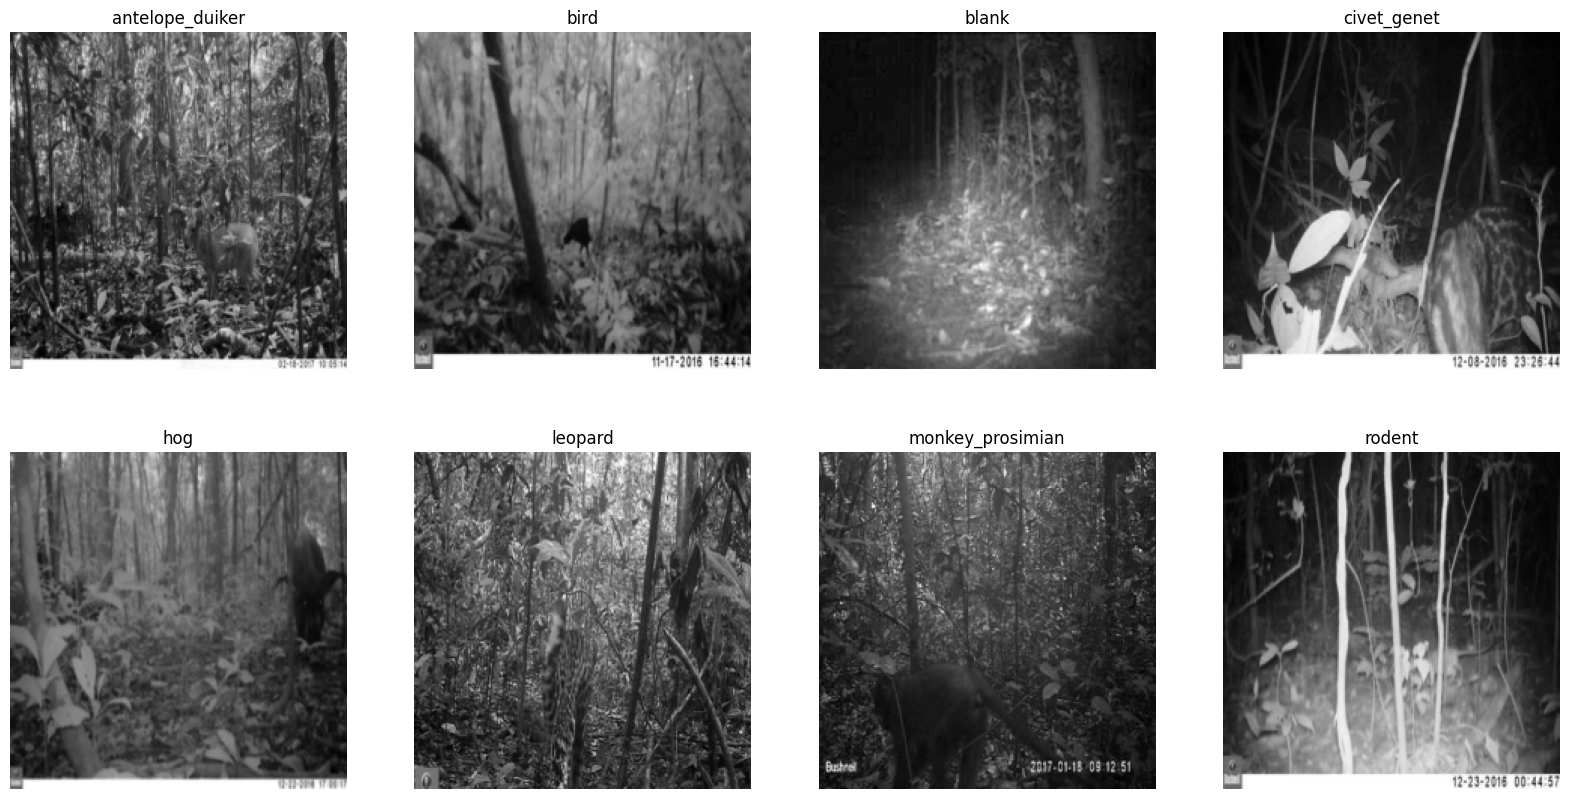

In [18]:
# for displaying original images
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for index, row in image_df.iterrows():
    img_path = row['img_path']
    mean_value = row['mean']
    std_value = row['std']

    transformed_image = custom_transform(img_path, mean_value, std_value)
    dense_transformed_image = transformed_image.cpu().detach().numpy().squeeze(0)
    dense_transformed_image = np.moveaxis(dense_transformed_image, 0, -1)
    ax = axs.flatten()[index]



    ax = axs.flatten()[index]
    ax.imshow(dense_transformed_image,  cmap='gray')
    ax.axis('off')
    ax.set_title(f"{row['animal']}")


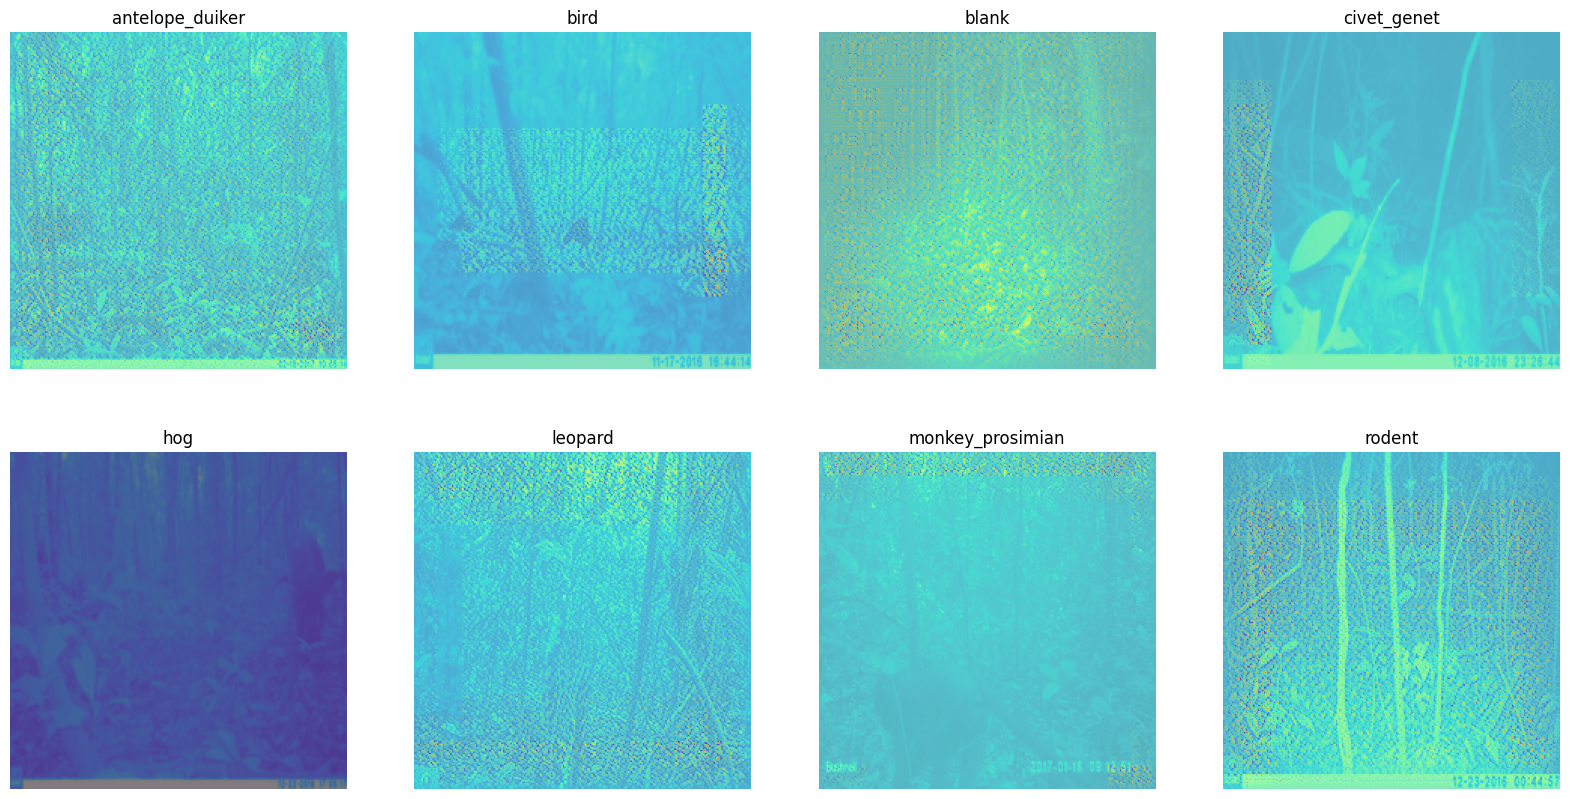

In [15]:
# for gradcam overlayed
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for index, row in image_df.iterrows():
    img_path = row['img_path']
    mean_value = row['mean']
    std_value = row['std']
    transformed_image = custom_transform(img_path, mean_value, std_value)
    dense_transformed_image = transformed_image.cpu().detach().numpy().squeeze(0)
    dense_transformed_image = np.moveaxis(dense_transformed_image, 0, -1)
    grad_cam_scores = grad_cam_scores_list[index]
    grad_cam_scores_cpu = grad_cam_scores.squeeze().cpu().detach().numpy()
    ax = axs.flatten()[index]

    ax = axs.flatten()[index]
    ax.imshow(grad_cam_scores_cpu, cmap='jet', alpha=0.7)
    ax.imshow(dense_transformed_image, alpha=0.3)
    ax.axis('off')
    ax.set_title(f"{row['animal']}")
